## Tweet Emotion Recognition: Natural Language Processing with TensorFlow

---

Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)


## Task 2: Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [1]:
!pip install nlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.8 MB/s eta 0:00:00


In [2]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()


print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.15.0


## Task 3: Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [6]:
pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 15.7 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [7]:
from datasets import load_dataset

dataset = load_dataset("dair-ai/emotion")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1486: FutureWarning: The repository for dair-ai/emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/dair-ai/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [29]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [30]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [38]:
def get_tweet(data):
  tweets = [x['text'] for x in data]
  labels = [x['label'] for x in data]
  return tweets, labels


label: a classification label, with possible values including sadness (0), joy (1), love (2), anger (3), fear (4), surprise (5).

In [45]:
label_dict ={
    0: 'sadness',
    1: 'joy',
    2: 'love',
    3: 'anger',
    4: 'fear',
    5: 'surprise'
}

In [39]:
tweets, labels = get_tweet(train)

In [46]:
tweets[1], label_dict[labels[1]]

('i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'sadness')

## Task 4: Tokenizer

1. Tokenizing the tweets

In [47]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [49]:
tokenizer= Tokenizer(num_words=1000, oov_token ='UNK')
tokenizer.fit_on_texts(tweets)

In [51]:
tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

## Task 5: Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

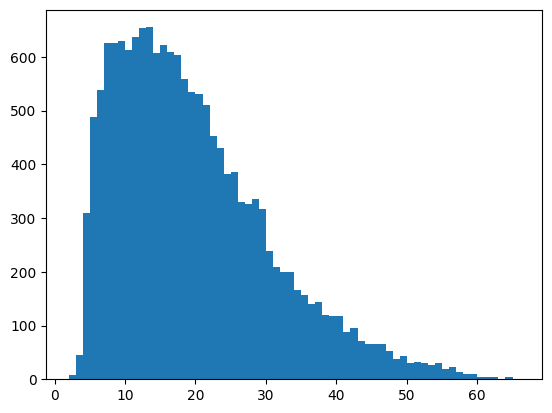

In [52]:
lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths, bins = len(set(lengths)))
plt.show()

In [53]:
maxlen = 50

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [54]:
def get_sequence(tokenizer, tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences,truncating='post', padding ='post', maxlen=maxlen)
  return padded

In [55]:
padded_train_sequence = get_sequence(tokenizer, tweets)

In [56]:
padded_train_sequence

array([[  2, 139,   3, ...,   0,   0,   0],
       [  2,  40, 101, ...,   0,   0,   0],
       [ 17,   1,   7, ...,   0,   0,   0],
       ...,
       [  2,   3, 327, ...,   0,   0,   0],
       [  2,   3,  14, ...,   0,   0,   0],
       [  2,  47,   7, ...,   0,   0,   0]], dtype=int32)

## Task 6: Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [62]:
classes = [label_dict[i] for i in labels]
print(set(classes))

{'anger', 'fear', 'surprise', 'love', 'sadness', 'joy'}


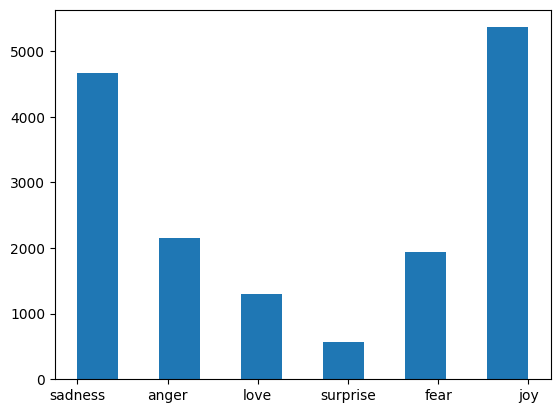

In [66]:
plt.hist(classes, bins = 11)
plt.show()

In [71]:
label_dict

{0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}

In [73]:
train_labels = labels
print(train_labels)

[0, 0, 3, 2, 3, 0, 5, 4, 1, 2, 0, 1, 3, 0, 1, 1, 0, 0, 0, 4, 3, 4, 1, 1, 3, 0, 0, 0, 3, 1, 1, 4, 5, 3, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 0, 0, 1, 2, 1, 3, 1, 0, 3, 4, 1, 0, 0, 5, 1, 1, 1, 2, 4, 4, 5, 3, 3, 0, 2, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 3, 0, 3, 3, 3, 1, 1, 1, 1, 0, 4, 2, 3, 0, 3, 2, 0, 1, 1, 0, 3, 2, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 2, 0, 0, 1, 1, 0, 1, 1, 4, 4, 4, 0, 2, 1, 1, 2, 4, 5, 1, 1, 1, 1, 3, 4, 1, 3, 2, 3, 0, 1, 0, 3, 1, 5, 0, 3, 3, 0, 1, 4, 1, 1, 4, 0, 5, 5, 1, 3, 4, 3, 0, 3, 0, 4, 0, 1, 5, 4, 1, 3, 1, 3, 1, 4, 4, 0, 1, 1, 0, 5, 1, 4, 1, 0, 1, 1, 1, 4, 1, 5, 1, 3, 0, 0, 1, 3, 0, 1, 1, 5, 1, 4, 1, 4, 0, 4, 2, 0, 4, 2, 0, 0, 3, 1, 2, 3, 0, 5, 3, 1, 0, 3, 1, 1, 1, 1, 1, 0, 1, 2, 1, 0, 3, 5, 1, 3, 1, 2, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 4, 0, 3, 0, 3, 2, 1, 2, 0, 1, 1, 1, 0, 1, 0, 3, 2, 0, 2, 0, 0, 0, 0, 0, 0, 4, 1, 0, 0, 1, 2, 0, 3, 0, 2, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 2, 4, 0, 4, 1, 1, 4, 1, 3, 3, 2, 0, 5, 1, 3, 0, 0, 3, 2, 5, 0, 2, 1, 3, 1, 0, 0, 1, 1, 4, 0, 3, 1, 2, 1, 1, 

## Task 7: Creating the Model

1. Creating the model
2. Compiling the model

In [80]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 16 , input_length= maxlen),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = 'adam',
    metrics =['accuracy']
)

In [82]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 50, 16)            160000    
                                                                 
 bidirectional_2 (Bidirecti  (None, 50, 40)            5920      
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 40)                9760      
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 6)                 246       
                                                                 
Total params: 175926 (687.21 KB)
Trainable params: 175926 (687.21 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Task 8: Training the Model

1. Preparing a validation set
2. Training the model

In [87]:
val_tweets, val_labels = get_tweet(val)
val_seq = get_sequence(tokenizer, val_tweets)
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 0)

In [ ]:
val_labels

In [86]:
val_seq

array([[ 17,   8, 157, ...,   0,   0,   0],
       [  2,   3,  14, ...,   0,   0,   0],
       [  2,   3,  14, ...,   0,   0,   0],
       ...,
       [  2,   3,  79, ...,   0,   0,   0],
       [  2, 395,   3, ...,   0,   0,   0],
       [  2,   3,  14, ...,   0,   0,   0]], dtype=int32)

In [93]:
h = model.fit(
    padded_train_sequence, np.array(train_labels),
    validation_data = (val_seq, np.array(val_labels)),
    epochs = 20,
    callbacks =[
        tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience=2)
    ]
)

Epoch 1/20
500/500 [==============================] - 31s 44ms/step - loss: 1.3966 - accuracy: 0.4499 - val_loss: 1.0068 - val_accuracy: 0.6485
Epoch 2/20
500/500 [==============================] - 9s 19ms/step - loss: 0.7653 - accuracy: 0.7281 - val_loss: 0.6650 - val_accuracy: 0.7745
Epoch 3/20
500/500 [==============================] - 8s 15ms/step - loss: 0.5707 - accuracy: 0.8050 - val_loss: 0.5386 - val_accuracy: 0.8190
Epoch 4/20
500/500 [==============================] - 8s 16ms/step - loss: 0.4664 - accuracy: 0.8431 - val_loss: 0.4632 - val_accuracy: 0.8430
Epoch 5/20
500/500 [==============================] - 8s 16ms/step - loss: 0.3824 - accuracy: 0.8716 - val_loss: 0.4983 - val_accuracy: 0.8345
Epoch 6/20
500/500 [==============================] - 8s 17ms/step - loss: 0.3499 - accuracy: 0.8783 - val_loss: 0.4222 - val_accuracy: 0.8555
Epoch 7/20
500/500 [==============================] - 8s 15ms/step - loss: 0.3172 - accuracy: 0.8879 - val_loss: 0.4031 - val_accuracy: 0.856

## Task 9: Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

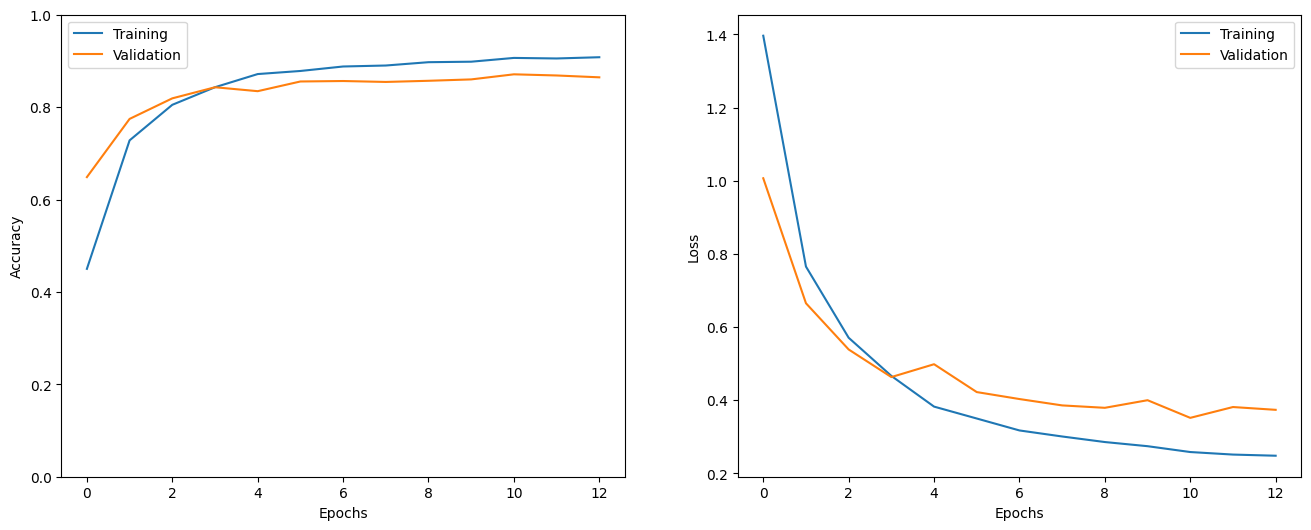

In [94]:
show_history(h)

In [95]:
test_tweets , test_labels = get_tweet(test)
test_seq = get_sequence(tokenizer, test_tweets)
test_labels = np.array(test_labels)

In [96]:
_  = model.evaluate(test_seq, test_labels)

63/63 [==============================] - 1s 14ms/step - loss: 0.4030 - accuracy: 0.8545


In [138]:
i = random.randint(0, len(test_labels)-1)
print('Sentence: ', test_tweets[i])
print('Emotion: ', label_dict[test_labels[i]])

p = model.predict(np.expand_dims(test_seq[i], axis =0))[0]
print(label_dict[np.argmax(p)])

Sentence:  i told him that i was willing to do whatever it took for me to not have to feel this horrible every day
Emotion:  sadness
1/1 [==============================] - 0s 21ms/step
sadness


In [130]:
preds = model.predict(test_seq)

63/63 [==============================] - 0s 6ms/step


In [136]:
preds_res = [np.argmax(i) for i in preds]

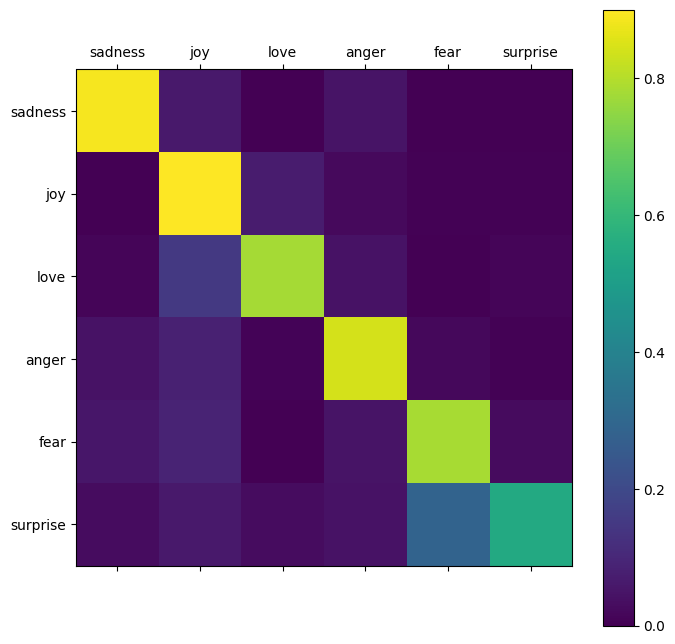

In [137]:
show_confusion_matrix(test_labels, preds_res, list(label_dict.values()))